In [13]:
import os
import time
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from pyhessian import hessian

from .. import evals
from ..models import ShallowNN

features = 197
batch_size = 64
loss_fn = torch.nn.L1Loss()

ImportError: attempted relative import with no known parent package

In [11]:
client_ids = ["0_0","0_1","0_2","0_3","0_4","0_5","1_0","1_1","1_2","1_3","1_4","1_5","2_0","2_1","2_2","2_3","2_4","2_5","3_0","3_1","3_2","3_3","3_4","3_5"]

In [121]:
#eigen_vectors = {}
eigen_client_dict = {}
for client in client_ids:
    client_data_loader = DataLoader(torch.load("trainpt/"+str(client)+".pt"), 64, shuffle = True)
    eigen_values = []
    for i in range (1,21):
        global_model = ShallowNN(features)
        checkpoint_path = os.path.join('checkpt', 'saving', 'epoch_500', f'global_{i}', 'global_model.pth')
        global_model.load_state_dict(torch.load(checkpoint_path))
        hessian_comp = hessian(global_model, loss_fn,  dataloader=data_loader, cuda=False)
        top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(maxIter=500)
        eigen_values.append(top_eigenvalues[0])
    eigen_client_dict[client] = eigen_values

In [153]:
pd.DataFrame.from_dict(eigen_client_dict).to_csv("insights/eigen_values_over_global_iter.csv", index=False)

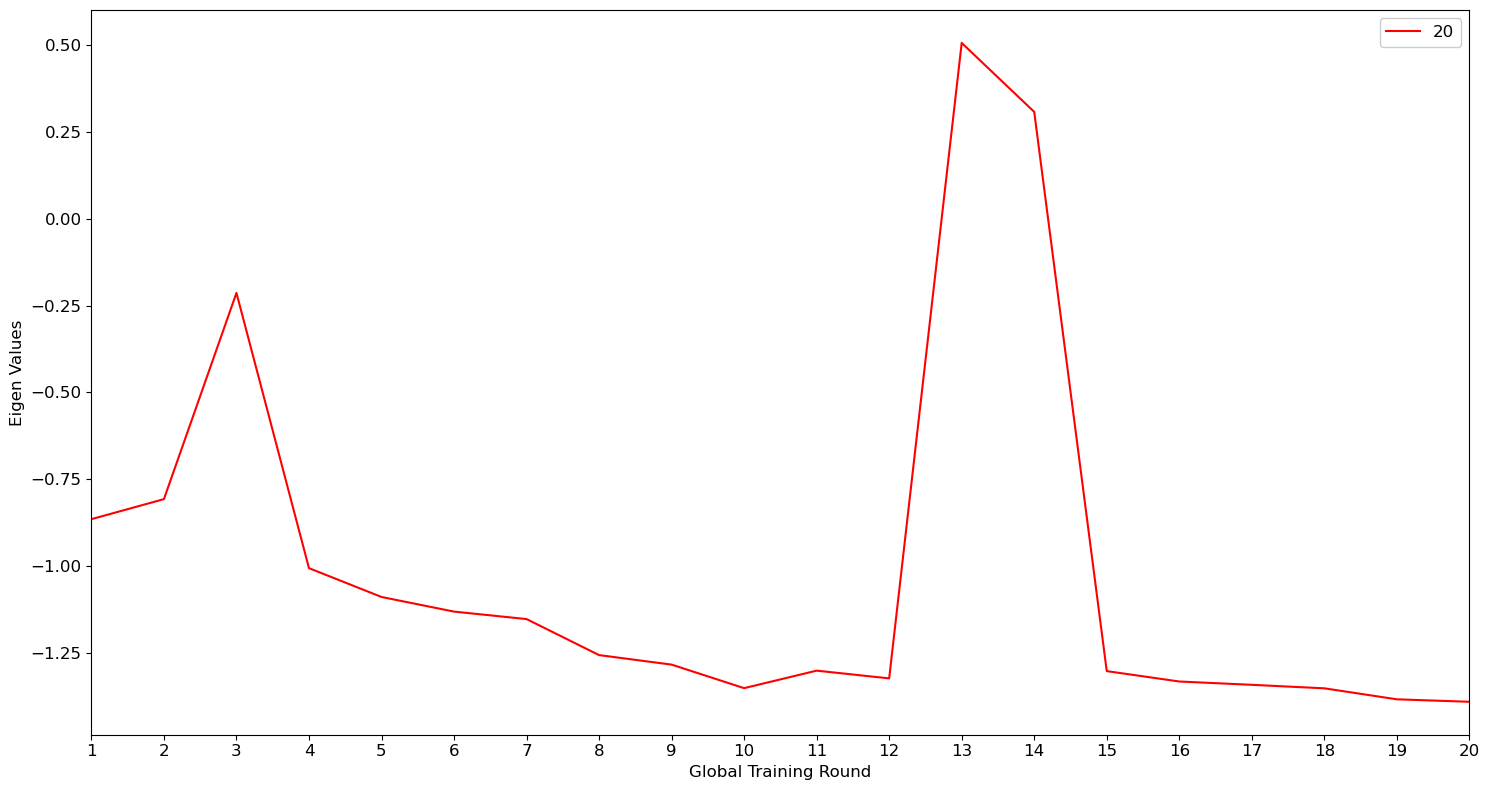

In [148]:
x_values = list(range(1, 21))

plt.figure(figsize=(15, 8))

for i, (key, values) in enumerate(eigen_client_dict.items()):
    if i+1 in [20]:
        plt.plot(x_values, values, label=str(i + 1),color='red')  # Set legend label from 1 to 24
    else:
        pass
        #plt.plot(x_values, values, label=str(i+1), color="gray")
    
plt.xlim(1,len(values))
#plt.ylim(bottom=0.035)
plt.xlabel('Global Training Round', fontsize='large')
plt.ylabel('Eigen Values', fontsize='large')
plt.legend(loc='upper right', ncol=4, bbox_to_anchor=(0,0,1,1), fontsize='large', framealpha=1)
plt.xticks(x_values, fontsize='large')
plt.yticks(fontsize='large')
plt.tight_layout()
plt.show()